In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=3619566e471aec54401be418956d7b0a678d37f9ce7512132945a4ab4969a200
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
!pip install kneed

In [ ]:
import pyspark
import pandas as pd
import seaborn as sns
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml.clustering import KMeans
from pyspark.mllib.clustering import KMeans as KM
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.clustering import KMeans as KM
from yellowbrick.cluster import KElbowVisualizer
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, when
from pyspark.sql import functions as f
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import expr, create_map, lit, col
from itertools import chain

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Caricamento Dataset

In [ ]:

spark = SparkSession.builder.appName("clustering").getOrCreate()

parquet_folder_path = '/content/drive/MyDrive/DDAM Personale/output.parquet'

df = spark.read.parquet(parquet_folder_path)

df.show()

+-------------------+--------------------+------+----+---------+--------+--------+-------+--------+-----+----------+---------+-------------------------+---------------------------------------+-------------------------------+-----------------+-----------+-------------------------------+---------------+--------------------+---------------+-------------+-------------------+-------------+--------+--------------------+----------+--------+--------+------------------+----------+-------------+------------------+-------+-------+---------+--------+-------------------+------------------+--------------------+-------------------+------------------------+------------------------+--------------------------+-------------------------+
|         FlightDate|             Airline|Origin|Dest|Cancelled|Diverted|DepDelay|AirTime|Distance|Month|DayofMonth|DayOfWeek|Marketing_Airline_Network|Operated_or_Branded_Code_Share_Partners|Flight_Number_Marketing_Airline|Operating_Airline|Tail_Number|Flight_Number_Oper

In [ ]:
sqlCtx= SQLContext(spark)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
df.printSchema()

root
 |-- FlightDate: timestamp_ntz (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Cancelled: boolean (nullable = true)
 |-- Diverted: boolean (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- Month: long (nullable = true)
 |-- DayofMonth: long (nullable = true)
 |-- DayOfWeek: long (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- Operated_or_Branded_Code_Share_Partners: string (nullable = true)
 |-- Flight_Number_Marketing_Airline: long (nullable = true)
 |-- Operating_Airline: string (nullable = true)
 |-- Tail_Number: string (nullable = true)
 |-- Flight_Number_Operating_Airline: long (nullable = true)
 |-- OriginAirportID: long (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- OriginStateName: string (nullable = true)
 |-- DestAirportID: long (nullable = 

#Filtro righe con ritardo sia alla partenza che all'arrivo


In [ ]:
# Filtra le righe con valori positivi nelle colonne "DepDelay" e "ArrDelay"
df_filtrato = df.filter((col("DepDelay") > 0) & (col("ArrDelay") > 0))

In [ ]:
df_filtrato.filter(df_filtrato["Diverted"] == "True").count()

0

#Colonne da droppare da df_filtrato

Colonne inutili da droppare
- FlightDate
- Cancelled
- Diverted



In [ ]:
# Lista di colonne da eliminare perchè inutili
columns_to_drop = ["FlightDate", "Cancelled", "Diverted", "DivAirportLandings",]

df_filtrato = df_filtrato.drop(*columns_to_drop)

df_filtrato.show()

+--------------------+------+----+--------+-------+--------+-----+----------+---------+-------------------------+---------------------------------------+-------------------------------+-----------------+-----------+-------------------------------+---------------+--------------------+---------------+-------------+-------------------+-------------+--------+--------------------+----------+--------+--------+------------------+----------+-------------+-------+-------+---------+--------+-------------------+------------------+--------------------+-------------------+------------------------+------------------------+--------------------------+-------------------------+
|             Airline|Origin|Dest|DepDelay|AirTime|Distance|Month|DayofMonth|DayOfWeek|Marketing_Airline_Network|Operated_or_Branded_Code_Share_Partners|Flight_Number_Marketing_Airline|Operating_Airline|Tail_Number|Flight_Number_Operating_Airline|OriginAirportID|      OriginCityName|OriginStateName|DestAirportID|       DestCityN

#Prove diverse non inserite nel report

##Creazione DF con dati numerici per 'outlier detection

In [ ]:
selected_columns = ["scaled_DepDelay", "scaled_AirTime", "scaled_Distance", "scaled_ArrDelay",
                    "scaled_DepTime_InMinutes", "scaled_ArrTime_InMinutes", "scaled_WheelsOff_InMinutes",
                    "scaled_WheelsOn_InMinutes"]

df_out = df_filtrato.select(*[col(column) for column in selected_columns])

df_out.show()

+-------------------+------------------+--------------------+-------------------+------------------------+------------------------+--------------------------+-------------------------+
|    scaled_DepDelay|    scaled_AirTime|     scaled_Distance|    scaled_ArrDelay|scaled_DepTime_InMinutes|scaled_ArrTime_InMinutes|scaled_WheelsOff_InMinutes|scaled_WheelsOn_InMinutes|
+-------------------+------------------+--------------------+-------------------+------------------------+------------------------+--------------------------+-------------------------+
| 0.3462227912932138|0.7216494845360825| 0.20961227786752828| 0.3472611464968153|      0.7581653926337735|      0.8978457261987491|        0.7810979847116053|       0.8895066018068103|
| 0.3344430217669654| 0.709278350515464|  0.1797253634894992|  0.338343949044586|      0.7331480194579569|      0.8790826963168867|        0.7428769979152189|       0.8763029881862404|
| 0.3574903969270166|0.6938144329896907| 0.14176090468497576|0.364076433121

##Outlier Detection

In [ ]:
df_out.show()

+-------------------+------------------+--------------------+-------------------+------------------------+------------------------+--------------------------+-------------------------+
|    scaled_DepDelay|    scaled_AirTime|     scaled_Distance|    scaled_ArrDelay|scaled_DepTime_InMinutes|scaled_ArrTime_InMinutes|scaled_WheelsOff_InMinutes|scaled_WheelsOn_InMinutes|
+-------------------+------------------+--------------------+-------------------+------------------------+------------------------+--------------------------+-------------------------+
| 0.3462227912932138|0.7216494845360825| 0.20961227786752828| 0.3472611464968153|      0.7581653926337735|      0.8978457261987491|        0.7810979847116053|       0.8895066018068103|
| 0.3344430217669654| 0.709278350515464|  0.1797253634894992|  0.338343949044586|      0.7331480194579569|      0.8790826963168867|        0.7428769979152189|       0.8763029881862404|
| 0.3574903969270166|0.6938144329896907| 0.14176090468497576|0.364076433121

##Boxplot vairiabili numeriche

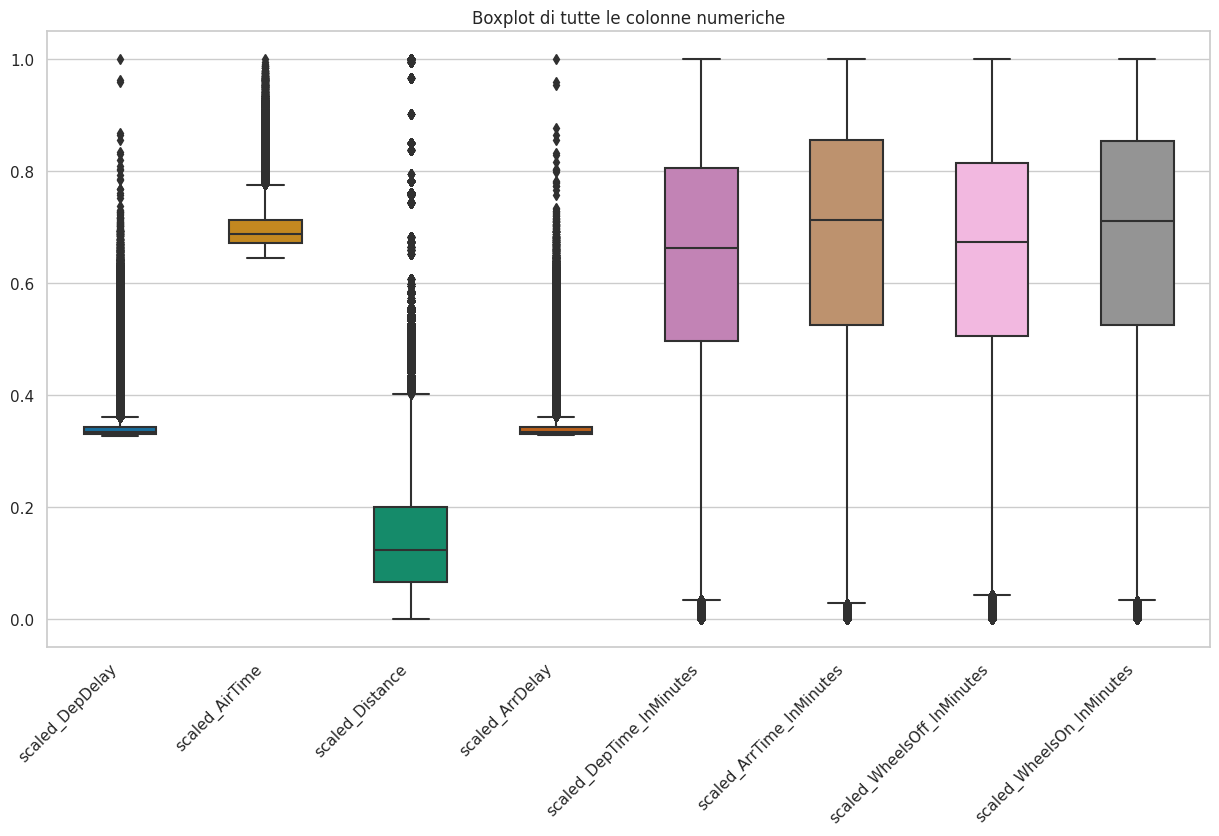

In [ ]:
colonne_numeriche = [col[0] for col in df_out.dtypes if col[1] in ["int", "double", "float"]]
df_numerico = df_out.select(*colonne_numeriche)

sns.set(style="whitegrid")
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_numerico.toPandas(), width=0.5, palette="colorblind")
plt.title('Boxplot di tutte le colonne numeriche')
plt.xticks(rotation=45, ha="right")
plt.show()


##Prova Outliers con altro codice

In [ ]:
numeric_columns = [column[0] for column in df_out.dtypes if column[1] in ['int', 'double', 'float']]
numeric_columns

['scaled_DepDelay',
 'scaled_AirTime',
 'scaled_Distance',
 'scaled_ArrDelay',
 'scaled_DepTime_InMinutes',
 'scaled_ArrTime_InMinutes',
 'scaled_WheelsOff_InMinutes',
 'scaled_WheelsOn_InMinutes']

In [ ]:
def find_outliers(df):

    numeric_columns = [column[0] for column in df_out.dtypes if column[1] in ['int', 'double', 'float']]

    for column in numeric_columns:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)


        IQR = Q3[0] - Q1[0]

        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR

        isOutlierCol = 'is_outlier_{}'.format(column)

        df = df.withColumn(isOutlierCol,f.when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))


    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]

    df = df.withColumn('total_outliers',sum(df[column] for column in selected_columns))

    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df

In [ ]:
new_df = find_outliers(df_out)
new_df.show()

NameError: ignored

In [ ]:
print(new_df.count()) #Righe del df_out
new_df.filter(new_df["total_outliers"] >= 1 ).count() #Righe del df con gli outlier
# Risultato metodo interquartile= (262473/1430384)*100= 18% di outliers, quindi li tengo

262473

In [ ]:
print(new_df.count())

1430384


In [ ]:
df_out= df_out.drop("features")

In [ ]:
df_out.show(50)

+-------------------+------------------+--------------------+-------------------+------------------------+------------------------+--------------------------+-------------------------+
|    scaled_DepDelay|    scaled_AirTime|     scaled_Distance|    scaled_ArrDelay|scaled_DepTime_InMinutes|scaled_ArrTime_InMinutes|scaled_WheelsOff_InMinutes|scaled_WheelsOn_InMinutes|
+-------------------+------------------+--------------------+-------------------+------------------------+------------------------+--------------------------+-------------------------+
| 0.3462227912932138|0.7216494845360825| 0.20961227786752828| 0.3472611464968153|      0.7581653926337735|      0.8978457261987491|        0.7810979847116053|       0.8895066018068103|
| 0.3344430217669654| 0.709278350515464|  0.1797253634894992|  0.338343949044586|      0.7331480194579569|      0.8790826963168867|        0.7428769979152189|       0.8763029881862404|
| 0.3574903969270166|0.6938144329896907| 0.14176090468497576|0.364076433121

In [ ]:
feature_columns = ["scaled_DepDelay", "scaled_AirTime", "scaled_Distance", "scaled_ArrDelay",
                    "scaled_DepTime_InMinutes", "scaled_ArrTime_InMinutes", "scaled_WheelsOff_InMinutes",
                    "scaled_WheelsOn_InMinutes"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_out = assembler.transform(df_out)


In [ ]:
df_out.show(10)

+-------------------+------------------+--------------------+-------------------+------------------------+------------------------+--------------------------+-------------------------+--------------------+
|    scaled_DepDelay|    scaled_AirTime|     scaled_Distance|    scaled_ArrDelay|scaled_DepTime_InMinutes|scaled_ArrTime_InMinutes|scaled_WheelsOff_InMinutes|scaled_WheelsOn_InMinutes|            features|
+-------------------+------------------+--------------------+-------------------+------------------------+------------------------+--------------------------+-------------------------+--------------------+
| 0.3462227912932138|0.7216494845360825| 0.20961227786752828| 0.3472611464968153|      0.7581653926337735|      0.8978457261987491|        0.7810979847116053|       0.8895066018068103|[0.34622279129321...|
| 0.3344430217669654| 0.709278350515464|  0.1797253634894992|  0.338343949044586|      0.7331480194579569|      0.8790826963168867|        0.7428769979152189|       0.876302988

In [ ]:
#Kmeans
wssse = {}
centers = {}
for k in range(2, 20):
    kmeans = KMeans(k=k, seed=1).fit(df_out.select("features"))
    wssse[k] = kmeans.computeCost(df_out.select("features"))
    centers[k] = kmeans.clusterCenters()

AttributeError: ignored

In [ ]:


wssse = {}
silhouette = {}
centers = {}

for k in range(2, 20):
    kmeans = KMeans(k=k, seed=1)
    model = kmeans.fit(df_out.select("features"))

    summary = model.summary
    wssse[k] = summary.trainingCost

    predictions = model.transform(df_out.select("features"))
    evaluator = ClusteringEvaluator()
    silhouette[k] = evaluator.evaluate(predictions)

    centers[k] = model.clusterCenters()


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: ignored

<ipython-input-20-8ce583897499>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


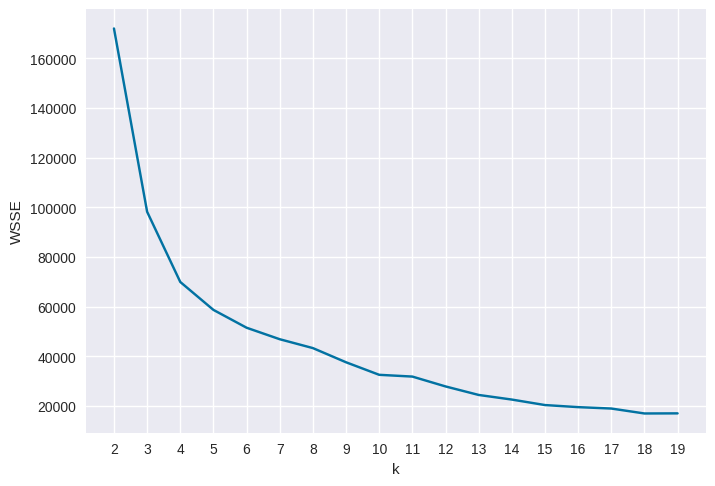

Numero ottimale di cluster (gomito): 5


In [ ]:
plt.figure()
plt.style.use('seaborn-darkgrid')
plt.xticks(range(2, 20, 1))
plt.plot(list(wssse.keys()), list(wssse.values()))
plt.xlabel("k")
plt.ylabel("WSSE")
plt.show()

kl = KneeLocator(
    range(2, 20), list(wssse.values()), curve="convex", direction="decreasing"
)

print("Numero ottimale di cluster (gomito):", kl.elbow)

In [ ]:
for i in range(2, 20):
    print("k = " + str(i) + "| WSSSE = " + str(wssse[i]))

KeyError: ignored

In [ ]:
for i in range(3, 15):
    kmeans = KMeans(k=i, seed=1)
    model = kmeans.fit(df_out)
    predictions = model.transform(df_out)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    print("Silhouette with squared euclidean distance  of", i," = " + str(silhouette))

Silhouette with squared euclidean distance  of 3  = 0.7027812833091314
Silhouette with squared euclidean distance  of 4  = 0.5978807336677467
Silhouette with squared euclidean distance  of 5  = 0.5099159841644074
Silhouette with squared euclidean distance  of 6  = 0.5471826365738667
Silhouette with squared euclidean distance  of 7  = 0.5617219107262773
Silhouette with squared euclidean distance  of 8  = 0.5369612830322916
Silhouette with squared euclidean distance  of 9  = 0.543795531028114
Silhouette with squared euclidean distance  of 10  = 0.5776248100836798
Silhouette with squared euclidean distance  of 11  = 0.44557228890662004
Silhouette with squared euclidean distance  of 12  = 0.5203671375780667
Silhouette with squared euclidean distance  of 13  = 0.5436073552073725
Silhouette with squared euclidean distance  of 14  = 0.524349695341911


#Clustering DF


##Clustering

In [ ]:
feature_columns = ["scaled_DepDelay", "scaled_AirTime", "scaled_Distance", "scaled_ArrDelay",
                    "scaled_DepTime_InMinutes", "scaled_ArrTime_InMinutes", "scaled_WheelsOff_InMinutes",
                    "scaled_WheelsOn_InMinutes"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_filtrato = assembler.transform(df_filtrato)


In [ ]:
df_filtrato.show(10)

+--------------------+------+----+--------+-------+--------+-----+----------+---------+-------------------------+---------------------------------------+-------------------------------+-----------------+-----------+-------------------------------+---------------+-----------------+---------------+-------------+-------------------+-------------+--------+--------------------+----------+--------+--------+------------------+----------+-------------+-------+-------+---------+--------+-------------------+------------------+--------------------+-------------------+------------------------+------------------------+--------------------------+-------------------------+--------------------+
|             Airline|Origin|Dest|DepDelay|AirTime|Distance|Month|DayofMonth|DayOfWeek|Marketing_Airline_Network|Operated_or_Branded_Code_Share_Partners|Flight_Number_Marketing_Airline|Operating_Airline|Tail_Number|Flight_Number_Operating_Airline|OriginAirportID|   OriginCityName|OriginStateName|DestAirportID| 

In [ ]:
wssse = {}
silhouette = {}
centers = {}

for k in range(2, 20):
    kmeans = KMeans(k=k, seed=1)
    model = kmeans.fit(df_filtrato.select("features"))

    summary = model.summary
    wssse[k] = summary.trainingCost

    predictions = model.transform(df_filtrato.select("features"))
    evaluator = ClusteringEvaluator()
    silhouette[k] = evaluator.evaluate(predictions)

    centers[k] = model.clusterCenters()


<ipython-input-23-8ce583897499>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


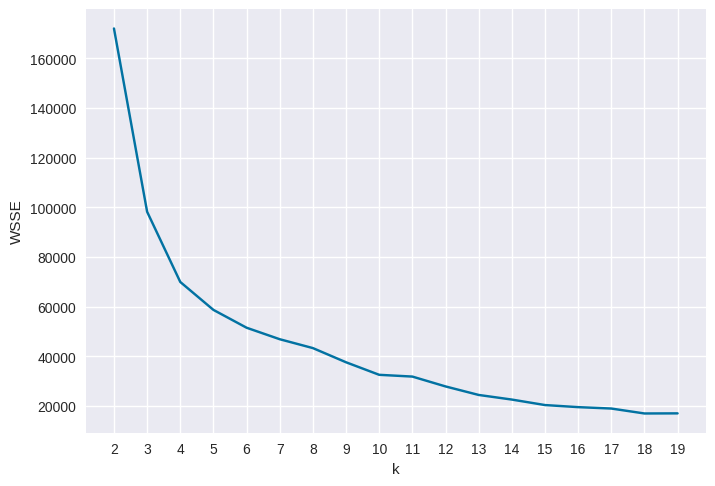

Numero ottimale di cluster (gomito): 5


In [ ]:
plt.figure()
plt.style.use('seaborn-darkgrid')
plt.xticks(range(2, 20, 1))
plt.plot(list(wssse.keys()), list(wssse.values()))
plt.xlabel("k")
plt.ylabel("WSSE")
plt.show()

kl = KneeLocator(
    range(2, 20), list(wssse.values()), curve="convex", direction="decreasing"
)

print("Numero ottimale di cluster (gomito):", kl.elbow)

In [ ]:
for i in range(2, 20):
    print("k = " + str(i) + "| WSSSE = " + str(wssse[i]))

k = 2| WSSSE = 172040.273898817
k = 3| WSSSE = 98227.21868272041
k = 4| WSSSE = 69938.19828074427
k = 5| WSSSE = 58689.959177002565
k = 6| WSSSE = 51508.3280108481
k = 7| WSSSE = 46874.438665720714
k = 8| WSSSE = 43302.82355335779
k = 9| WSSSE = 37590.27824736812
k = 10| WSSSE = 32540.791730275545
k = 11| WSSSE = 31831.430097428718
k = 12| WSSSE = 27863.15559485993
k = 13| WSSSE = 24431.616738708646
k = 14| WSSSE = 22571.05524677208
k = 15| WSSSE = 20360.064393110108
k = 16| WSSSE = 19522.51789100111
k = 17| WSSSE = 18958.90429355722
k = 18| WSSSE = 16969.758999867267
k = 19| WSSSE = 17013.23574263072


In [ ]:
for i in range(2, 19):
    kmeans = KMeans(k=i, seed=1)
    model = kmeans.fit(df_filtrato.select("features"))
    predictions = model.transform(df_filtrato.select("features"))
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    print("Silhouette with squared euclidean distance  of", i," = " + str(silhouette))

Silhouette with squared euclidean distance  of 2  = 0.6116899779762213
Silhouette with squared euclidean distance  of 3  = 0.7027812833091314
Silhouette with squared euclidean distance  of 4  = 0.5978807336677467
Silhouette with squared euclidean distance  of 5  = 0.5099159841644074
Silhouette with squared euclidean distance  of 6  = 0.5471826365738667
Silhouette with squared euclidean distance  of 7  = 0.5617219107262773
Silhouette with squared euclidean distance  of 8  = 0.5369612830322916
Silhouette with squared euclidean distance  of 9  = 0.543795531028114
Silhouette with squared euclidean distance  of 10  = 0.5776248100836798
Silhouette with squared euclidean distance  of 11  = 0.44557228890662004
Silhouette with squared euclidean distance  of 12  = 0.5203671375780667
Silhouette with squared euclidean distance  of 13  = 0.5436073552073725
Silhouette with squared euclidean distance  of 14  = 0.524349695341911
Silhouette with squared euclidean distance  of 15  = 0.5155096920966382
S

##Kmeans con 4 clusters

In [ ]:
kmeans = KMeans(k=4, seed=1)
model = kmeans.fit(df_filtrato.select("features"))
predictions_kmeans = model.transform(df_filtrato)


In [ ]:
predictions_kmeans.show()

+--------------------+------+----+--------+-------+--------+-----+----------+---------+-------------------------+---------------------------------------+-------------------------------+-----------------+-----------+-------------------------------+---------------+--------------------+---------------+-------------+-------------------+-------------+--------+--------------------+----------+--------+--------+------------------+----------+-------------+-------+-------+---------+--------+-------------------+------------------+--------------------+-------------------+------------------------+------------------------+--------------------------+-------------------------+--------------------+----------+
|             Airline|Origin|Dest|DepDelay|AirTime|Distance|Month|DayofMonth|DayOfWeek|Marketing_Airline_Network|Operated_or_Branded_Code_Share_Partners|Flight_Number_Marketing_Airline|Operating_Airline|Tail_Number|Flight_Number_Operating_Airline|OriginAirportID|      OriginCityName|OriginStateNam

In [ ]:
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[0.34697302 0.71702239 0.22606112 0.34701207 0.91632034 0.06268808
 0.91648016 0.05816856]
[0.34109254 0.69642924 0.14530809 0.34156335 0.80202182 0.88901804
 0.81497421 0.88374059]
[0.3390649  0.69740925 0.15007304 0.33973057 0.59259775 0.67113875
 0.60544122 0.6852995 ]
[0.34024925 0.69796716 0.15027562 0.34094399 0.3615761  0.43620207
 0.35733477 0.43111412]


##PCA con cluster

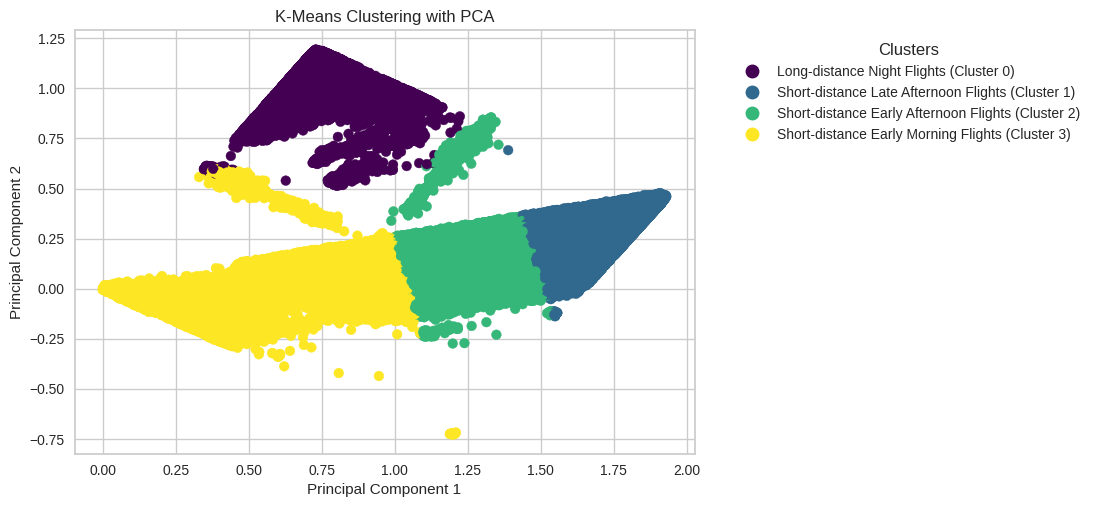

In [ ]:
scatter = plt.scatter(x, y, c=labels, cmap='viridis')
plt.title('K-Means Clustering with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

unique_labels = list(set(labels))
legend_labels = ['Long-distance Night Flights', 'Short-distance Late Afternoon Flights',
                 'Short-distance Early Afternoon Flights', 'Short-distance Early Morning Flights']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.to_rgba(label), markersize=10) for label in unique_labels]
plt.legend(legend_handles, [f'{legend_labels[label]} (Cluster {label})' for label in unique_labels], title='Clusters', loc='upper left', bbox_to_anchor=(1.05, 1.0))

plt.show()

##Radar Chart

<ipython-input-51-dc19802fda2d>:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["DepDelay", "AirTime", "Distance", "ArrDelay",


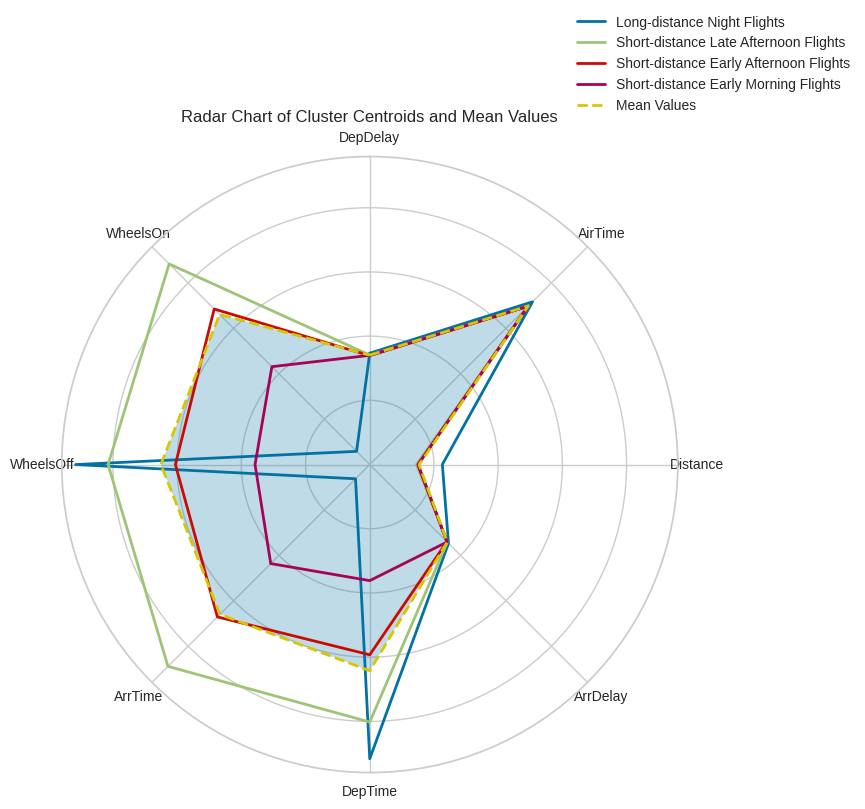

In [ ]:
centroids = model.clusterCenters()

mean_values = np.mean(df_filtrato.select("scaled_DepDelay", "scaled_AirTime", "scaled_Distance", "scaled_ArrDelay",
                                        "scaled_DepTime_InMinutes", "scaled_ArrTime_InMinutes", "scaled_WheelsOff_InMinutes",
                                        "scaled_WheelsOn_InMinutes").collect(), axis=0)

legend_labels = ['Long-distance Night Flights', 'Short-distance Late Afternoon Flights',
                 'Short-distance Early Afternoon Flights', 'Short-distance Early Morning Flights', 'Mean Values']

num_clusters = len(centroids)
num_features = len(centroids[0])

centroids_transposed = np.array(centroids).T

angles = np.linspace(0, 2 * np.pi, num_features, endpoint=False).tolist()
angles += angles[:1]
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_rlabel_position(0)

for i in range(num_clusters):
    values = centroids_transposed[:, i].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=legend_labels[i])

mean_values = mean_values.tolist()
mean_values += mean_values[:1]
ax.plot(angles, mean_values, linewidth=2, linestyle='dashed', label=legend_labels[-1])

ax.fill(angles, mean_values, alpha=0.25)
ax.set_yticklabels([])
ax.set_xticklabels(["DepDelay", "AirTime", "Distance", "ArrDelay",
                    "DepTime", "ArrTime", "WheelsOff", "WheelsOn"])
plt.title('Radar Chart of Cluster Centroids and Mean Values')
plt.legend(loc='upper right', bbox_to_anchor=(1.30, 1.25))
plt.show()


##Trasformazioni features Month e DayOfWeek



In [ ]:
colonne_categoriche = ["Month", "DayOfWeek"]

mesi_mapping = {1: "January", 2: "February", 3: "March", 4: "April", 5: "May", 6: "June", 7: "July", 8: "August", 9: "September", 10: "October", 11: "November", 12: "December"}
giorni_mapping = {1: "Monday", 2: "Tuesday", 3: "Wednesday", 4: "Thursday", 5: "Friday", 6: "Saturday", 7: "Sunday"}

month_mapping_expr = create_map([lit(x) for x in chain(*mesi_mapping.items())])

day_of_week_mapping_expr = create_map([lit(x) for x in chain(*giorni_mapping.items())])

df_km = predictions_kmeans.withColumn("Month_mapped", month_mapping_expr[col("Month")])
df_km = df_km.withColumn("DayOfWeek_mapped", day_of_week_mapping_expr[col("DayOfWeek")])

df_km.show()


+--------------------+------+----+--------+-------+--------+-----+----------+---------+-------------------------+---------------------------------------+-------------------------------+-----------------+-----------+-------------------------------+---------------+--------------------+---------------+-------------+-------------------+-------------+--------+--------------------+----------+--------+--------+------------------+----------+-------------+-------+-------+---------+--------+-------------------+------------------+--------------------+-------------------+------------------------+------------------------+--------------------------+-------------------------+--------------------+----------+------------+----------------+
|             Airline|Origin|Dest|DepDelay|AirTime|Distance|Month|DayofMonth|DayOfWeek|Marketing_Airline_Network|Operated_or_Branded_Code_Share_Partners|Flight_Number_Marketing_Airline|Operating_Airline|Tail_Number|Flight_Number_Operating_Airline|OriginAirportID|     

##Analisi Clustering

In [ ]:
df_km.printSchema()

root
 |-- Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- Month: long (nullable = true)
 |-- DayofMonth: long (nullable = true)
 |-- DayOfWeek: long (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- Operated_or_Branded_Code_Share_Partners: string (nullable = true)
 |-- Flight_Number_Marketing_Airline: long (nullable = true)
 |-- Operating_Airline: string (nullable = true)
 |-- Tail_Number: string (nullable = true)
 |-- Flight_Number_Operating_Airline: long (nullable = true)
 |-- OriginAirportID: long (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- OriginStateName: string (nullable = true)
 |-- DestAirportID: long (nullable = true)
 |-- DestCityName: string (nullable = true)
 |-- DestStateName: string (nullable = true)
 |-- DepDel15: double (nullable = true)
 |-- DepartureDelayGroups: double (nullable = true)
 |-- DepTimeBlk: string 

In [ ]:
df_km.show()

+--------------------+------+----+--------+-------+--------+-----+----------+---------+-------------------------+---------------------------------------+-------------------------------+-----------------+-----------+-------------------------------+---------------+--------------------+---------------+-------------+-------------------+-------------+--------+--------------------+----------+--------+--------+------------------+----------+-------------+-------+-------+---------+--------+-------------------+------------------+--------------------+-------------------+------------------------+------------------------+--------------------------+-------------------------+--------------------+----------+------------+----------------+
|             Airline|Origin|Dest|DepDelay|AirTime|Distance|Month|DayofMonth|DayOfWeek|Marketing_Airline_Network|Operated_or_Branded_Code_Share_Partners|Flight_Number_Marketing_Airline|Operating_Airline|Tail_Number|Flight_Number_Operating_Airline|OriginAirportID|     

In [ ]:
def basic_statistics(df):
    for feature, data_type in df.dtypes:
        if data_type == 'int' or data_type == 'double':

            median_value = df.selectExpr(f"percentile_approx({feature}, 0.5)").collect()[0][0]

            print(f"Median of {feature}: {median_value}")
            df.describe(feature).show(truncate=False)


In [ ]:
features_tosel = ["Airline", "Origin", "Dest", "DepDelay", "Month_mapped",
                  "DayofMonth", "DayOfWeek_mapped", "Marketing_Airline_Network", "OriginCityName", "OriginStateName",
                  "DestCityName", "DestStateName", "DepTimeBlk", "ArrTimeBlk", "AirTime",
                   "Distance", "ArrDelay"]

In [ ]:
features_numeric = ["DepDelay", "AirTime",
                   "Distance", "ArrDelay"]

In [ ]:
features_notnumeric = ["Airline", "Origin", "Dest", "Month_mapped",
                  "DayofMonth", "DayOfWeek_mapped", "Marketing_Airline_Network", "OriginCityName", "OriginStateName",
                    "DestCityName", "DestStateName", "DepTimeBlk", "ArrTimeBlk",   ]


In [ ]:
df_km.show(5)

+--------------------+------+----+--------+-------+--------+-----+----------+---------+-------------------------+---------------------------------------+-------------------------------+-----------------+-----------+-------------------------------+---------------+---------------+---------------+-------------+-------------------+-------------+--------+--------------------+----------+--------+--------+------------------+----------+-------------+-------+-------+---------+--------+-------------------+------------------+--------------------+-------------------+------------------------+------------------------+--------------------------+-------------------------+--------------------+----------+------------+----------------+
|             Airline|Origin|Dest|DepDelay|AirTime|Distance|Month|DayofMonth|DayOfWeek|Marketing_Airline_Network|Operated_or_Branded_Code_Share_Partners|Flight_Number_Marketing_Airline|Operating_Airline|Tail_Number|Flight_Number_Operating_Airline|OriginAirportID| OriginCit

In [ ]:
#Dizionario con le features_tosel per ogni cluster
dist_clusters = df_km.select("prediction").distinct().rdd.map(lambda x: x[0]).collect()
dd = {}
for i in dist_clusters:
    dd[i] = df_km.filter(df_km["prediction"] == i).select(features_tosel)

In [ ]:
dd

{1: DataFrame[Airline: string, Origin: string, Dest: string, DepDelay: double, Month_mapped: string, DayofMonth: bigint, DayOfWeek_mapped: string, Marketing_Airline_Network: string, OriginCityName: string, OriginStateName: string, DestCityName: string, DestStateName: string, DepTimeBlk: string, ArrTimeBlk: string, AirTime: double, Distance: double, ArrDelay: double],
 3: DataFrame[Airline: string, Origin: string, Dest: string, DepDelay: double, Month_mapped: string, DayofMonth: bigint, DayOfWeek_mapped: string, Marketing_Airline_Network: string, OriginCityName: string, OriginStateName: string, DestCityName: string, DestStateName: string, DepTimeBlk: string, ArrTimeBlk: string, AirTime: double, Distance: double, ArrDelay: double],
 2: DataFrame[Airline: string, Origin: string, Dest: string, DepDelay: double, Month_mapped: string, DayofMonth: bigint, DayOfWeek_mapped: string, Marketing_Airline_Network: string, OriginCityName: string, OriginStateName: string, DestCityName: string, DestSta

In [ ]:
#Print delle statistische numeriche di ogni cluster
for cluster, df_cluster in dd.items():
    print(f"\nStatistics for Cluster {cluster}")
    basic_statistics(df_cluster)


Statistics for Cluster 1
Median of DepDelay: 31.0
+-------+------------------+
|summary|DepDelay          |
+-------+------------------+
|count  |531314            |
|mean   |51.94793474292038 |
|stddev |63.367986159107915|
|min    |1.0               |
|max    |2468.0            |
+-------+------------------+

Median of AirTime: 90.0
+-------+------------------+
|summary|AirTime           |
+-------+------------------+
|count  |531314            |
|mean   |107.07951983196378|
|stddev |66.61989970136479 |
|min    |7.0               |
|max    |601.0             |
+-------+------------------+

Median of Distance: 610.0
+-------+-----------------+
|summary|Distance         |
+-------+-----------------+
|count  |531314           |
|mean   |750.6300342170543|
|stddev |537.9643411086221|
|min    |31.0             |
|max    |4983.0           |
+-------+-----------------+

Median of ArrDelay: 29.0
+-------+-----------------+
|summary|ArrDelay         |
+-------+-----------------+
|count  |5313

In [ ]:
#Print con le statistiche della variabile categoriche dei cluster con valori in ordine decrescente
for i in dist_clusters:
    print("----------- Info categorici cluster n°: " + str(i) + " --------")
    for j in features_notnumeric:
        dd[i].createOrReplaceTempView("tmp")
        tot_j = dd[i].select(j).count()
        query = spark.sql("SELECT "+str(j)+", count(*)/"+str(tot_j)+" * 100 FROM tmp GROUP BY "+ str(j) + " ORDER BY count(*) DESC")
        print("<<-- feature:"+ str(j))
        query.show()

----------- Info categorici cluster n°: 1 --------
<<-- feature:Airline
+--------------------+---------------------------+
|             Airline|((count(1) / 531314) * 100)|
+--------------------+---------------------------+
|Southwest Airline...|          33.56226261683298|
|United Air Lines ...|           9.31784217995385|
|SkyWest Airlines ...|          7.067195669604039|
|American Airlines...|          6.735753245726632|
|     JetBlue Airways|           6.55092845285462|
|Delta Air Lines Inc.|          5.372529238830523|
|   Republic Airlines|         3.0571375871894966|
|ExpressJet Airlin...|          2.653045091979507|
|Frontier Airlines...|          2.650033690058986|
|    Spirit Air Lines|          2.573619366325751|
|  Mesa Airlines Inc.|          2.425872459600161|
|Alaska Airlines Inc.|          2.121344440387417|
|       Allegiant Air|          2.075796986339528|
|         Comair Inc.|         1.9673865172007514|
|           Envoy Air|         1.7659990137658712|
|   Endeav

##Count per clusters

In [ ]:
cluster_counts = df_km.groupBy("prediction").count()


cluster_counts.show()

+----------+------+
|prediction| count|
+----------+------+
|         1|531314|
|         3|308207|
|         2|494619|
|         0| 96244|
+----------+------+

